# Objective

Using data from Taarifa and the Tanzanian Ministry of Water, we create a model to predict which pumps are **functional**, which need **some repairs**, and which **don't work at all** based on a number of variables about what kind of pump is operating, when it was installed, and how it is managed. A good understanding of which water pumps will fail can improve maintenance operations and ensure that clean, potable water is available to communities across Tanzania.

This predictive modeling challenge comes from DrivenData, an organization that helps non-profits by hosting data science competitions for social impact. The competition has open licensing: "The data is available for use outside of DrivenData." \

Dataset source: [DrivenData.org](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/).

# Setting up

In [ ]:
 %%capture
 !pip install category_encoders==2.*
 !pip install pandas-profiling==2.*

Datasets saved to personal google drive so setup includes retrieval from this space

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
%cd /content/gdrive/My Drive/Kaggle


/content/gdrive/My Drive/Kaggle


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
#!kaggle competitions download -c ds36-water-pump-challenge 

In [ ]:
!unzip \*.zip  && rm *.zip

unzip:  cannot find or open *.zip, *.zip.zip or *.zip.ZIP.

No zipfiles found.


Sanity check to make sure files I want to work with are in there.

In [ ]:
!ls

2022-02-17_0217_submission.csv	sample_submission.csv  train_features.csv
first_submission.csv		second_submission.csv  train_labels.csv
fourth_submission.csv		test_features.csv
kaggle.json			third_submission.csv


# Decision Trees

Our goal is to create a model to predict whether a water pump is functional, non-functional, or needs repair.


# Import Data

In [ ]:
import pandas as pd

In [ ]:
train_features = pd.read_csv('train_features.csv')
train_features.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,454,50.0,2013-02-27,Dmdd,2092,DMDD,35.426020,-4.227446,Narmo,0,...,per bucket,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
1,510,0.0,2011-03-17,Cmsr,0,Gove,35.510074,-5.724555,Lukali,0,...,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump
2,14146,0.0,2011-07-10,Kkkt,0,KKKT,32.499866,-9.081222,Mahakama,0,...,never pay,soft,good,enough,enough,shallow well,shallow well,groundwater,other,other
3,47410,0.0,2011-04-12,NaN,0,NaN,34.060484,-8.830208,Shule Ya Msingi Chosi A,0,...,monthly,soft,good,insufficient,insufficient,river,river/lake,surface,communal standpipe,communal standpipe
4,1288,300.0,2011-04-05,Ki,1023,Ki,37.032690,-6.040787,Kwa Mjowe,0,...,on failure,salty,salty,enough,enough,shallow well,shallow well,groundwater,other,other


In [ ]:
train_labels = pd.read_csv('train_labels.csv')
train_labels.head()

,id,status_group
0,454,functional
1,510,functional
2,14146,non functional
3,47410,non functional
4,1288,non functional


In [ ]:
train = pd.merge(pd.read_csv('train_features.csv',na_values=[0,-2.000000e-08]),
                  pd.read_csv('train_labels.csv', na_values=[0,-2.000000e-08]))
train.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,454.0,50.0,2013-02-27,Dmdd,2092.0,DMDD,35.426020,-4.227446,Narmo,NaN,...,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,510.0,NaN,2011-03-17,Cmsr,NaN,Gove,35.510074,-5.724555,Lukali,NaN,...,soft,good,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional
2,14146.0,NaN,2011-07-10,Kkkt,NaN,KKKT,32.499866,-9.081222,Mahakama,NaN,...,soft,good,enough,enough,shallow well,shallow well,groundwater,other,other,non functional
3,47410.0,NaN,2011-04-12,NaN,NaN,NaN,34.060484,-8.830208,Shule Ya Msingi Chosi A,NaN,...,soft,good,insufficient,insufficient,river,river/lake,surface,communal standpipe,communal standpipe,non functional
4,1288.0,300.0,2011-04-05,Ki,1023.0,Ki,37.032690,-6.040787,Kwa Mjowe,NaN,...,salty,salty,enough,enough,shallow well,shallow well,groundwater,other,other,non functional


# Exploratory Data Analysis

In [ ]:
from pandas_profiling import ProfileReport
Report = ProfileReport(train, minimal=True).to_notebook_iframe()
Report

Summarize dataset:   0%|          | 0/49 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
train.head(100).T.duplicated()

id                       False
amount_tsh               False
date_recorded            False
funder                   False
gps_height               False
installer                False
longitude                False
latitude                 False
wpt_name                 False
num_private              False
basin                    False
subvillage               False
region                   False
region_code              False
district_code            False
lga                      False
ward                     False
population               False
public_meeting           False
recorded_by              False
scheme_management        False
scheme_name              False
permit                   False
construction_year        False
extraction_type          False
extraction_type_group    False
extraction_type_class    False
management               False
management_group         False
payment                  False
payment_type             False
water_quality            False
quality_

Editing wrangle function as we go with each new insight on high cardinality columns or columns with large amount of missing data.

In [ ]:
#Exploring complete datset columns

import pandas as pd
import numpy as np

df_complete = pd.read_csv('train_features.csv')
X_test_complete = pd.read_csv('test_features.csv')

print(df_complete.shape)
print(X_test_complete.shape)

#Exploring  new 'age' feature added in class
df_complete['date_recorded'].value_counts()
#type(df_complete['date_recorded'])
df_complete['date_recorded']= pd.to_datetime(df_complete['date_recorded'])
type(df_complete['date_recorded'])
df_complete.dtypes #confirmed datetime conversion

#extract year to see how many unique years there are
year = df_complete['date_recorded'].dt.year
year.unique() #looks like we have 4 unique years: 2004, 2011,2012,2013
#all years set in the past so does not actualoy give us the age of the pump
#To get true age we must subract year pump was constructed from current year:2022
df_complete['pump_age']= 2022 - df_complete['construction_year']
df_complete['pump_age'].head()
df_complete['construction_year'] #looks like we got zeros where we should have NaNs
#We will replace the 0's with NaNs so we can replace with SimpleImputer(mean) in our pipeline
df_complete['construction_year'].value_counts() #we have 16,503 zeroes which bring our mean way down to ~1300
#Replace 0's with NaNs
df_complete['construction_year'] = df_complete['construction_year'].replace(0, np.nan)
df_complete['construction_year'] #confirming that it worked!!
df_complete['construction_year'].mean() #new mean is 1996
df_complete['construction_year'].median() #median is 2000
df_complete['construction_year'].mode() #mode is 2010
#For SimpleImputer I'll use mode first
#want to see what happens when I subtract with nan values
df_complete['pump_age']= 2022 - df_complete['construction_year']
df_complete['pump_age'] #We get Nans. Perfect!

#paste this into wrangle function and modify variables as needed
df_complete['construction_year'] = df_complete['construction_year'].replace(0, np.nan)
df_complete['pump_age']= 2022 - df_complete['construction_year']
#in retrospect creating age feature might be redundant because of construction year
#but at least we got the NaN values into contruction year

(47520, 40)
(11880, 40)


# Wrangle Data

In [ ]:
import pandas as pd
import numpy as np


def wrangle(fm_path, tv_path=None):
    if tv_path:
        df = pd.merge(pd.read_csv(fm_path, 
                                  na_values=[0, -2.000000e-08]),
                      pd.read_csv(tv_path)).set_index('id')
    else:
        df = pd.read_csv(fm_path, 
                         na_values=[0, -2.000000e-08],
                         index_col='id')
    
    #Replace zeros with NaNs to get accurate mean later with SimpleImputer
    df['construction_year'] = df['construction_year'].replace(0, np.nan)
    
    #Create age feature
    df['pump_age'] = 2022 - df['construction_year']
    
    # Drop constant columns
    df.drop(columns=['recorded_by'], inplace=True)

    # Drop HCCCs
    cutoff = 300
    drop_cols = [col for col in df.select_dtypes('object').columns
                 if df[col].nunique() > cutoff]
    df.drop(columns=drop_cols, inplace=True)
    df.drop(columns=['lga'], inplace=True)

    # Drop duplicate columns
    dupe_cols = [col for col in df.head(15).T.duplicated().index
                 if df.head(20).T.duplicated()[col]]
    df.drop(columns=dupe_cols, inplace=True)
    #missed one phrased differently, same as 'payment_type'
    df.drop(columns=['payment'], inplace=True)
    df.drop(columns=['source_type'], inplace=True)
    df.drop(columns=['extraction_type'], inplace=True)
    df.drop(columns=['management'], inplace=True)
    df.drop(columns=['waterpoint_type_group'], inplace=True)
    
    # Drop columns with high proportion of null values
    df.drop(columns=['num_private'], inplace=True)             
    df.drop(columns=['amount_tsh'], inplace=True)
    return df

Using the `wrangle` function above, we read the `train_features.csv` and  `train_labels.csv` files into the DataFrame `df`. Next, we use the same function to read the test set `test_features.csv` into the DataFrame `X_test`.

In [ ]:
df = wrangle('train_features.csv', 'train_labels.csv')

X_test = wrangle('test_features.csv')

df.head()

,gps_height,longitude,latitude,basin,region,region_code,district_code,population,public_meeting,scheme_management,...,management_group,payment_type,water_quality,quality_group,quantity,source,source_class,waterpoint_type,status_group,pump_age
id,,,,,,,,,,,,,,,,,,,,,
454.0,2092.0,35.426020,-4.227446,Internal,Manyara,21,1.0,160.0,True,Water Board,...,user-group,per bucket,soft,good,insufficient,spring,groundwater,communal standpipe,functional,24.0
510.0,NaN,35.510074,-5.724555,Internal,Dodoma,1,6.0,NaN,True,VWC,...,user-group,never pay,soft,good,enough,shallow well,groundwater,hand pump,functional,NaN
14146.0,NaN,32.499866,-9.081222,Lake Rukwa,Mbeya,12,6.0,NaN,True,VWC,...,user-group,never pay,soft,good,enough,shallow well,groundwater,other,non functional,NaN
47410.0,NaN,34.060484,-8.830208,Rufiji,Mbeya,12,7.0,NaN,True,VWC,...,user-group,monthly,soft,good,insufficient,river,surface,communal standpipe,non functional,NaN
1288.0,1023.0,37.032690,-6.040787,Wami / Ruvu,Morogoro,5,1.0,120.0,True,VWC,...,user-group,on failure,salty,salty,enough,shallow well,groundwater,other,non functional,25.0


In [ ]:
X_test.head(15)

,gps_height,longitude,latitude,basin,region,region_code,district_code,population,public_meeting,scheme_management,...,extraction_type_class,management_group,payment_type,water_quality,quality_group,quantity,source,source_class,waterpoint_type,pump_age
id,,,,,,,,,,,,,,,,,,,,,
37098,NaN,31.985658,-3.596360,Lake Tanganyika,Shinyanga,17,5.0,NaN,True,WUG,...,other,user-group,unknown,soft,good,dry,shallow well,groundwater,other,NaN
14530,NaN,32.832815,-4.944937,Lake Tanganyika,Tabora,14,6.0,NaN,True,VWC,...,handpump,user-group,never pay,milky,milky,insufficient,shallow well,groundwater,hand pump,NaN
62607,1675.0,35.488289,-4.242048,Internal,Manyara,21,1.0,148.0,True,Water Board,...,gravity,user-group,per bucket,soft,good,insufficient,spring,groundwater,communal standpipe,14.0
46053,NaN,33.140828,-9.059386,Lake Rukwa,Mbeya,12,6.0,NaN,False,VWC,...,handpump,user-group,never pay,soft,good,seasonal,shallow well,groundwater,hand pump,NaN
47083,1109.0,34.217077,-4.430529,Internal,Singida,13,1.0,235.0,True,WUA,...,motorpump,user-group,per bucket,soft,good,enough,machine dbh,groundwater,communal standpipe multiple,11.0
12465,149.0,38.987944,-8.314887,Rufiji,Pwani,60,53.0,1.0,True,VWC,...,other,user-group,never pay,soft,good,enough,machine dbh,groundwater,communal standpipe multiple,13.0
12921,NaN,31.418240,-1.606798,Lake Victoria,Kagera,18,2.0,NaN,True,VWC,...,gravity,user-group,never pay,soft,good,seasonal,rainwater harvesting,surface,communal standpipe,NaN
14606,1333.0,35.465845,-7.711371,Rufiji,Iringa,11,1.0,1.0,True,VWC,...,gravity,user-group,annually,soft,good,dry,spring,groundwater,communal standpipe,28.0
9417,NaN,30.983023,-1.680654,Lake Victoria,Kagera,18,1.0,NaN,True,NaN,...,gravity,commercial,never pay,soft,good,dry,rainwater harvesting,surface,communal standpipe,NaN


In [ ]:
X_test.shape

(11880, 27)

In [ ]:
df.shape

(47519, 28)

In [ ]:
df.columns

Index(['amount_tsh', 'gps_height', 'longitude', 'latitude', 'basin', 'region',
       'region_code', 'district_code', 'population', 'public_meeting',
       'scheme_management', 'permit', 'construction_year', 'extraction_type',
       'extraction_type_class', 'management', 'management_group', 'payment',
       'payment_type', 'water_quality', 'quality_group', 'quantity', 'source',
       'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group', 'status_group'],
      dtype='object')

In [ ]:
#df['num_private'].nunique()

# Features

- amount_tsh: Total static head (amount water available to waterpoint)
- date_recorded: The date the row was entered
- funder: Who funded the well
- gps_height: Altitude of the well
- installer: Organization that installed the well
- longitude: GPS coordinate
- latitude: GPS coordinate
- wpt_name: Name of the waterpoint if there is one
- num_private:
- basin: Geographic water basin
- subvillage: Geographic location
- region: Geographic location
- region_code: Geographic location (coded)
- district_code: Geographic location (coded)
- lga: Geographic location
- ward: Geographic location
- population: Population around the well
- public_meeting: True/False
- recorded_by: Group entering this row of data
- scheme_management: Who operates the waterpoint
- scheme_name: Who operates the waterpoint
- permit: If the waterpoint is permitted
- construction_year: Year the waterpoint was constructed
- extraction_type: The kind of extraction the waterpoint uses
- extraction_type_group: The kind of extraction the waterpoint uses
- extraction_type_class: The kind of extraction the waterpoint uses
- management: How the waterpoint is managed
- management_group: How the waterpoint is managed
- payment: What the water costs
- payment_type: What the water costs
- water_quality: The quality of the water
- quality_group: The quality of the water
- quantity: The quantity of water
- quantity_group: The quantity of water
- source: The source of the water
- source_type: The source of the water
- source_class: The source of the water
- waterpoint_type: The kind of waterpoint
- waterpoint_type_group: The kind of waterpoint


# II. Split Data

Splitting DataFrame `df` into a feature matrix `X` and the target vector `y`. We want to predict `'status_group'`.

In [ ]:
target ='status_group'

X = df.drop(columns=target)
y = df['status_group']

Using a randomized split, we divide `X` and `y` into a training set (`X_train`, `y_train`) and a validation set (`X_val`, `y_val`).

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.2, random_state=42)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((38015, 22), (9504, 22), (38015,), (9504,))

# Establish Baseline
Since this is a **classification** problem, we establish a baseline accuracy score by figuring out what the majority class is in `y_train` and what percentage of our training observations it represents.

In [ ]:
y_train.value_counts(normalize=True)

functional                 0.542549
non functional             0.384348
functional needs repair    0.073103
Name: status_group, dtype: float64

According to this, it appears the majority class was the functional group consisting of 54% out of all possible outcomes.

In [ ]:
baseline_acc = y_train.value_counts(normalize=True).max()
print('Baseline Accuracy Score:', baseline_acc)

Baseline Accuracy Score: 0.5425489938182296


# Build Model

We build a model with `DecisionTreeClassifier`and set the `random_state` parameter for reproduceability.

In [ ]:
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier

model_dt = make_pipeline(OrdinalEncoder(),
                         SimpleImputer(strategy='mean'),
                         DecisionTreeClassifier(random_state=42))

model_dt.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['basin', 'region', 'public_meeting',
                                      'scheme_management', 'permit',
                                      'extraction_type_class',
                                      'management_group', 'payment_type',
                                      'water_quality', 'quality_group',
                                      'quantity', 'source', 'source_class',
                                      'waterpoint_type'],
                                mapping=[{'col': 'basin',
                                          'data_type': dtype('O'),
                                          'mapping': Lake Victoria              1
Lake Tanganyika            2
Ruv...
                                          'data_type': dtype('O'),
                                          'mapping': groundwater    1
surface        2
unknown        3
NaN           -2
dtype: int64},
                                

# Check Metrics

Calculating the training and validation accuracy scores for `model_dt`.

In [ ]:
from sklearn.metrics import accuracy_score

training_acc = accuracy_score(y_train, model_dt.predict(X_train))
val_acc = accuracy_score(y_val, model_dt.predict(X_val))

print('Training Accuracy Score:', training_acc)
print('Validation Accuracy Score:', val_acc)

Training Accuracy Score: 0.994791529659345
Validation Accuracy Score: 0.7443181818181818


# Tune Model

Since there is a big discrepancy between our training and valiation accuracies we will experiment with different settings for `max_depth` in our `DecisionTreeClassifier` to reduce the amount of overfitting in our model.

In [ ]:
# Use this cell to experiment and then change 
# our model hyperparameters

depths = range(1, 50, 1)
list(depths)

train_acc = []
val_acc = []

for depth in depths:

  tree_model = make_pipeline(
      OrdinalEncoder(),
      SimpleImputer(),
      DecisionTreeClassifier(max_depth=depth, random_state=42)
  )

  tree_model.fit(X_train, y_train)

  train_acc.append(tree_model.score(X_train, y_train))
  val_acc.append(tree_model.score(X_val, y_val))


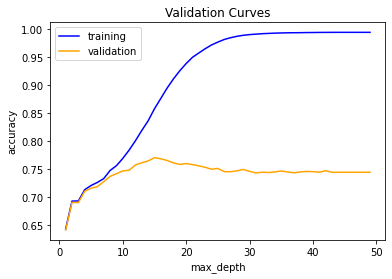

In [ ]:
import matplotlib.pyplot as plt

plt.plot(depths, train_acc, color='blue', label='training')
plt.plot(depths, val_acc, color='orange', label='validation')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.title('Validation Curves') # These plots are called VALIDATION CURVES! 
plt.legend()
plt.show()

From studying the chart above, we see that the highest accuracy reached by our validation data was with the max_depth set around 15

In [ ]:
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier

model_dt = make_pipeline(OrdinalEncoder(),
                         SimpleImputer(strategy='mean'),
                         DecisionTreeClassifier(max_depth = 15, random_state=42))

model_dt.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['basin', 'region', 'public_meeting',
                                      'scheme_management', 'permit',
                                      'extraction_type_class',
                                      'management_group', 'payment_type',
                                      'water_quality', 'quality_group',
                                      'quantity', 'source', 'source_class',
                                      'waterpoint_type'],
                                mapping=[{'col': 'basin',
                                          'data_type': dtype('O'),
                                          'mapping': Lake Victoria              1
Lake Tanganyika            2
Ruv...
                                          'data_type': dtype('O'),
                                          'mapping': groundwater    1
surface        2
unknown        3
NaN           -2
dtype: int64},
                                

In [ ]:
# with max_depth = 14
training_acc = accuracy_score(y_train, model_dt.predict(X_train))
val_acc = accuracy_score(y_val, model_dt.predict(X_val))

print('Training Accuracy Score:', training_acc)
print('Validation Accuracy Score:', val_acc)

Training Accuracy Score: 0.8362751545442588
Validation Accuracy Score: 0.7646254208754208


In [ ]:
# with max_depth = 15
training_acc = accuracy_score(y_train, model_dt.predict(X_train))
val_acc = accuracy_score(y_val, model_dt.predict(X_val))

print('Training Accuracy Score:', training_acc)
print('Validation Accuracy Score:', val_acc)

Training Accuracy Score: 0.8578981980797054
Validation Accuracy Score: 0.7704124579124579


In [ ]:
# with max_depth = 16
training_acc = accuracy_score(y_train, model_dt.predict(X_train))
val_acc = accuracy_score(y_val, model_dt.predict(X_val))

print('Training Accuracy Score:', training_acc)
print('Validation Accuracy Score:', val_acc)

Training Accuracy Score: 0.8764172037353676
Validation Accuracy Score: 0.7685185185185185


In [ ]:
# with max_depth = 17
training_acc = accuracy_score(y_train, model_dt.predict(X_train))
val_acc = accuracy_score(y_val, model_dt.predict(X_val))

print('Training Accuracy Score:', training_acc)
print('Validation Accuracy Score:', val_acc)

Training Accuracy Score: 0.8950677364198343
Validation Accuracy Score: 0.7653619528619529


Validation accuracy seems to stagnate after 15 so we will keep our model with a `max_depth` of `15`

# Communicate Results

This horizontal barchart shows the the 10 most important features for model_dt, sorted by value.

**Note:** [`DecisionTreeClassifier.feature_importances_`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html?highlight=decisiontreecla#sklearn.tree.DecisionTreeClassifier.feature_importances_) returns values will be positive, and they will sum to `1`.

Text(0.5, 0, 'gini importance')

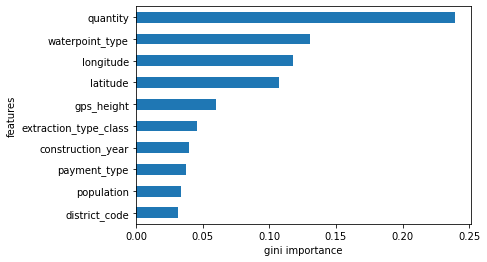

In [ ]:
features = model_dt.named_steps['ordinalencoder'].get_feature_names()
gini = model_dt.named_steps['decisiontreeclassifier'].feature_importances_
pd.Series(data=gini, index=features).sort_values(key=abs).tail(10).plot(kind='barh')
plt.ylabel('features')
plt.xlabel('gini importance')

It appears that the quantity of water going through a pump is the greatest determining factor for whether it is functional, nonfunctional, or needs repair, which does make a lot of sense considering the more use we get out of something, the more likely we are to damage it.

# Different Model: RandomForestClassifier
Now we will see if making a Random forest Classifier will improve our results

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model_rf = make_pipeline(OrdinalEncoder(),
                         SimpleImputer(strategy='mean'),
                         RandomForestClassifier(random_state=42))

model_rf.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['basin', 'region', 'public_meeting',
                                      'scheme_management', 'permit',
                                      'extraction_type_class',
                                      'management_group', 'payment_type',
                                      'water_quality', 'quality_group',
                                      'quantity', 'source', 'source_class',
                                      'waterpoint_type'],
                                mapping=[{'col': 'basin',
                                          'data_type': dtype('O'),
                                          'mapping': Lake Victoria              1
Lake Tanganyika            2
Ruv...
                                          'data_type': dtype('O'),
                                          'mapping': groundwater    1
surface        2
unknown        3
NaN           -2
dtype: int64},
                                

In [ ]:
training_acc = accuracy_score(y_train, model_rf.predict(X_train))
val_acc = accuracy_score(y_val, model_rf.predict(X_val))

print('Training Accuracy Score:', training_acc)
print('Validation Accuracy Score:', val_acc)

Training Accuracy Score: 0.9947126134420623
Validation Accuracy Score: 0.7933501683501684


# Tune Model

In [ ]:
# Use this cell to experiment

depths = range(10, 30, 5)
list(depths)

train_acc = []
val_acc = []

for depth in depths:

  tree_model = make_pipeline(
      OrdinalEncoder(),
      SimpleImputer(),
      RandomForestClassifier(max_depth=depth, random_state=42)
  )

  tree_model.fit(X_train, y_train)

  train_acc.append(tree_model.score(X_train, y_train))
  val_acc.append(tree_model.score(X_val, y_val))

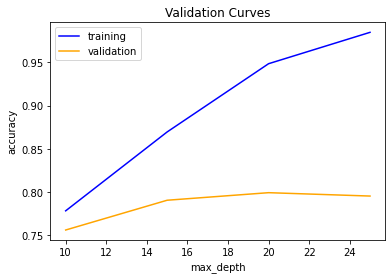

In [ ]:
plt.plot(depths, train_acc, color='blue', label='training')
plt.plot(depths, val_acc, color='orange', label='validation')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.title('Validation Curves') # These plots are called VALIDATION CURVES 
plt.legend()
plt.show()

Accuracy seems to peak around 20

In [ ]:
model_rf = make_pipeline(OrdinalEncoder(),
                         SimpleImputer(strategy='mean'),
                         RandomForestClassifier(max_depth = 20, random_state=42))

model_rf.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['basin', 'region', 'public_meeting',
                                      'scheme_management', 'permit',
                                      'extraction_type_class',
                                      'management_group', 'payment_type',
                                      'water_quality', 'quality_group',
                                      'quantity', 'source', 'source_class',
                                      'waterpoint_type'],
                                mapping=[{'col': 'basin',
                                          'data_type': dtype('O'),
                                          'mapping': Lake Victoria              1
Lake Tanganyika            2
Ruv...
                                          'data_type': dtype('O'),
                                          'mapping': groundwater    1
surface        2
unknown        3
NaN           -2
dtype: int64},
                                

In [ ]:
# with max_depth = 18
training_acc = accuracy_score(y_train, model_rf.predict(X_train))
val_acc = accuracy_score(y_val, model_rf.predict(X_val))

print('Training Accuracy Score:', training_acc)
print('Validation Accuracy Score:', val_acc)

Training Accuracy Score: 0.919821123240826
Validation Accuracy Score: 0.7976641414141414


In [ ]:
# with max_depth = 19
training_acc = accuracy_score(y_train, model_rf.predict(X_train))
val_acc = accuracy_score(y_val, model_rf.predict(X_val))

print('Training Accuracy Score:', training_acc)
print('Validation Accuracy Score:', val_acc)

Training Accuracy Score: 0.935920031566487
Validation Accuracy Score: 0.7993476430976431


In [ ]:
# with max_depth = 20
training_acc = accuracy_score(y_train, model_rf.predict(X_train))
val_acc = accuracy_score(y_val, model_rf.predict(X_val))

print('Training Accuracy Score:', training_acc)
print('Validation Accuracy Score:', val_acc)

Training Accuracy Score: 0.9485203209259503
Validation Accuracy Score: 0.7994528619528619


In [ ]:
# with max_depth = 21
training_acc = accuracy_score(y_train, model_rf.predict(X_train))
val_acc = accuracy_score(y_val, model_rf.predict(X_val))

print('Training Accuracy Score:', training_acc)
print('Validation Accuracy Score:', val_acc)

Training Accuracy Score: 0.9603840589241089
Validation Accuracy Score: 0.7985058922558923


To reiterate the best scores we got from DecisionTreeClassifer were: \

Training Accuracy Score: 0.85789\
Validation Accuracy Score: 0.77041

Best scores for RandomForestClassofier were: \

Training Accuracy Score: 0.94852\
Validation Accuracy Score: 0.79945


# Communicate Results

Text(0.5, 0, 'gini importance')

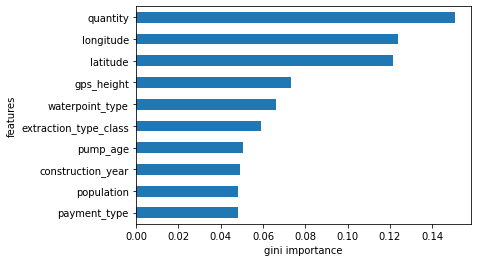

In [ ]:
features = model_rf.named_steps['ordinalencoder'].get_feature_names()
gini = model_rf.named_steps['randomforestclassifier'].feature_importances_
pd.Series(data=gini, index=features).sort_values(key=abs).tail(10).plot(kind='barh')
plt.ylabel('features')
plt.xlabel('gini importance')

The top influencing feature for the RandomForestClassifier model was the same as the DecisionTreeClassifier model, although the next two are different by one feature, that being `longitude` and `latitude` as opposed to `waterpoint_type` and `longitude`

Since the RandomForestClassifier performed better that the DecisionTreeClassifier we are going to perform a GridSearch on the Random Forest Classifier to see if we could fine-tune some of it's hyperparameters and achieve an even better accuracy.\
We'll start with a RandomizedSearch to narrow down our field of vision

# RandomizedSearchCV

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
model =  make_pipeline(OrdinalEncoder(),
                       SimpleImputer(),
                       RandomForestClassifier(random_state=42, n_jobs=-1))

param_grid = {'simpleimputer__strategy': ['mean', 'median'],
              'randomforestclassifier__min_samples_leaf': range(2,5,1),
              'randomforestclassifier__max_features':  range(12,16,1),
              'randomforestclassifier__max_depth': range(15,25,3)}

model_rand_search = RandomizedSearchCV(model,
                                       param_distributions=param_grid,
                                       n_jobs=-1, cv=5, verbose=1, n_iter=10)
model_rand_search.fit(X,y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('ordinalencoder',
                                              OrdinalEncoder()),
                                             ('simpleimputer', SimpleImputer()),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(n_jobs=-1,
                                                                     random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'randomforestclassifier__max_depth': range(15, 25, 3),
                                        'randomforestclassifier__max_features': range(12, 16),
                                        'randomforestclassifier__min_samples_leaf': range(2, 5),
                                        'simpleimputer__strategy': ['mean',
                                                                    'median']},
                   verbose=1)

In [ ]:
model_rand_search.best_params_

{'randomforestclassifier__max_depth': 21,
 'randomforestclassifier__max_features': 15,
 'randomforestclassifier__min_samples_leaf': 2,
 'simpleimputer__strategy': 'median'}

In [ ]:
model_rand_search.best_score_

0.8039310286916306

# GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV
model =  make_pipeline(OrdinalEncoder(),
                       SimpleImputer(),
                       RandomForestClassifier(random_state=42))

param_grid = {'simpleimputer__strategy': ['mean', 'median'],
              'randomforestclassifier__min_samples_leaf': range(1,3,1),
              'randomforestclassifier__max_features':  range(12,14,1),
              'randomforestclassifier__max_depth': range(20,22,1)}

model_gridsearch = GridSearchCV(model, param_grid=param_grid, n_jobs=1, cv=5, verbose=1)
model_gridsearch.fit(X,y)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ordinalencoder', OrdinalEncoder()),
                                       ('simpleimputer', SimpleImputer()),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=1,
             param_grid={'randomforestclassifier__max_depth': range(20, 22),
                         'randomforestclassifier__max_features': range(12, 14),
                         'randomforestclassifier__min_samples_leaf': range(1, 3),
                         'simpleimputer__strategy': ['mean', 'median']},
             verbose=1)

In [ ]:
model_gridsearch.best_params_

{'randomforestclassifier__max_depth': 21,
 'randomforestclassifier__max_features': 13,
 'randomforestclassifier__min_samples_leaf': 2,
 'simpleimputer__strategy': 'mean'}

In [ ]:
model_gridsearch.best_score_
print('Best score for `model`:',model_gridsearch.best_score_)

Best score for `model`: 0.8051515607688658


# Communicate Results

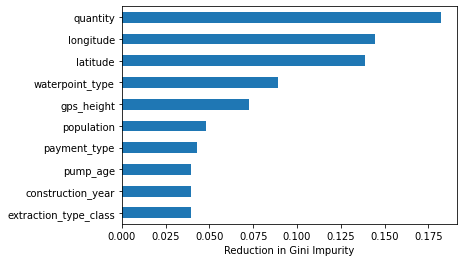

In [ ]:
import matplotlib.pyplot as plt

bestimator = model_gridsearch.best_estimator_
importances = bestimator.named_steps['randomforestclassifier'].feature_importances_
features = X.columns
feat_imp = pd.Series(importances, index=features).sort_values()

feat_imp.tail(10).plot(kind='barh')
plt.xlabel('Reduction in Gini Impurity');

No change in feature importances

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


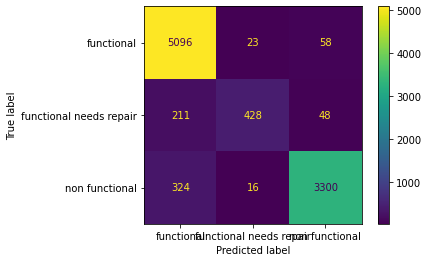

In [ ]:
# Plot 3x3 confusion matrix
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(model_gridsearch.best_estimator_,
                      X_val,
                      y_val,
                      values_format ='.0f',
                      #display_labels = []
                      );

**Precision Score**

Of all the pumps predicted as needing repair, this is the proportion that **actually** needed repair

**Recall Score** 

Of those pumps that actually needed repair, this is the proportion that were **correctly** predicted as needing repair

In [ ]:
# Print classification report 
from sklearn.metrics import classification_report
print(classification_report(y_val,
                            model_gridsearch.best_estimator_.predict(X_val)))

                         precision    recall  f1-score   support

             functional       0.90      0.98      0.94      5177
functional needs repair       0.92      0.62      0.74       687
         non functional       0.97      0.91      0.94      3640

               accuracy                           0.93      9504
              macro avg       0.93      0.84      0.87      9504
           weighted avg       0.93      0.93      0.93      9504



# Identify the top 100 non-functional pumps that are most likely to need repair.

These will be the pumps prioritized when looking at which pumps to go repair first. We will be implementing the predict-probabilities method and then select only nonfunctional pumps where the model is more than 95% certain that a pump is `non functional` according to the predicted probabilities and then merge that with our `population` data column in order to prioritize pumps with the largest associated populations. \
Using our best model:

In [ ]:
final_model_rf = make_pipeline(OrdinalEncoder(),
                         SimpleImputer(strategy='mean'),
                         RandomForestClassifier(max_depth = 21,
                                                max_features = 13,
                                                min_samples_leaf = 2,
                                                random_state=42))

final_model_rf.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['basin', 'region', 'public_meeting',
                                      'scheme_management', 'permit',
                                      'extraction_type_class',
                                      'management_group', 'payment_type',
                                      'water_quality', 'quality_group',
                                      'quantity', 'source', 'source_class',
                                      'waterpoint_type'],
                                mapping=[{'col': 'basin',
                                          'data_type': dtype('O'),
                                          'mapping': Lake Victoria              1
Lake Tanganyika            2
Ruv...
surface        2
unknown        3
NaN           -2
dtype: int64},
                                         {'col': 'waterpoint_type',
                                          'data_type': dtype('O'),
                                  

In [ ]:
training_acc = accuracy_score(y_train, final_model_rf.predict(X_train))
val_acc = accuracy_score(y_val, final_model_rf.predict(X_val))

print('Training Accuracy Score:', training_acc)
print('Validation Accuracy Score:', val_acc)

Training Accuracy Score: 0.9278179665921347
Validation Accuracy Score: 0.7976641414141414


In [ ]:
n_inspections = 100
data = {'y_val': y_val,
        'y_pred': final_model_rf.predict(X_val),
        'y_pred_proba':final_model_rf.predict_proba(X_val)[:,2]} #[:,2] refers to the all
                                                        # the contents of the last 
                                                        # column in my model.predict_proba 
                                                        # matrix with 3 columns
                                                        # since this column contains the 
                                                        # non-functional pumps

results = pd.DataFrame(data)

In [ ]:
results.head()

,y_val,y_pred,y_pred_proba
id,,,
8492.0,functional needs repair,functional,0.101374
16772.0,non functional,non functional,1.000000
19506.0,functional,non functional,0.580672
40301.0,non functional,non functional,0.520695
61519.0,functional,functional,0.074525


In [ ]:
threshold=0.95
mask=(results['y_pred_proba'] > threshold)

X_test_nf = results[mask] #.sample(n_inspections)
X_test_nf.head()

,y_val,y_pred,y_pred_proba
id,,,
16772.0,non functional,non functional,1.000000
4125.0,non functional,non functional,0.995000
12693.0,non functional,non functional,0.999101
20316.0,non functional,non functional,0.995000
47371.0,non functional,non functional,0.970333


In [ ]:
# confirming which column contains the population data from validation set
X_val.columns

Index(['gps_height', 'longitude', 'latitude', 'basin', 'region', 'region_code',
       'district_code', 'population', 'public_meeting', 'scheme_management',
       'permit', 'construction_year', 'extraction_type_class',
       'management_group', 'payment_type', 'water_quality', 'quality_group',
       'quantity', 'source', 'source_class', 'waterpoint_type', 'pump_age'],
      dtype='object')

In [ ]:
# MERGING probabilities and Population
X_test_nf = X_test_nf.merge(X_val['population'], left_index=True, right_index=True)
X_test_nf.shape
X_test_nf.head()

,y_val,y_pred,y_pred_proba,population
id,,,,
16772.0,non functional,non functional,1.000000,1.0
4125.0,non functional,non functional,0.995000,1000.0
12693.0,non functional,non functional,0.999101,NaN
20316.0,non functional,non functional,0.995000,80.0
47371.0,non functional,non functional,0.970333,59.0


In [ ]:
# Sorting and extracting only the top 100
X_test_nf = X_test_nf.sort_values(by='population', ascending=False).head(100)
print(X_test_nf.shape)
X_test_nf.head()

(100, 4)


,y_val,y_pred,y_pred_proba,population
id,,,,
60369.0,non functional,non functional,0.963500,6000.0
61740.0,non functional,non functional,0.991667,3241.0
21905.0,non functional,non functional,0.961667,3200.0
56913.0,non functional,non functional,0.987500,2530.0
59972.0,non functional,non functional,0.985000,2300.0


# Communicate Results
Scatter plot with the location of the 100 pumps in `X_test_nf`

In [ ]:
# Merging longitude
X_test_nf_long = X_test_nf.merge(X_val['longitude'], left_index=True, right_index=True)
X_test_nf_long.shape

(100, 5)

In [ ]:
# Merging latitude
X_test_nf_location = X_test_nf_long.merge(X_val['latitude'], left_index=True, right_index=True)
X_test_nf_location.shape

(100, 6)

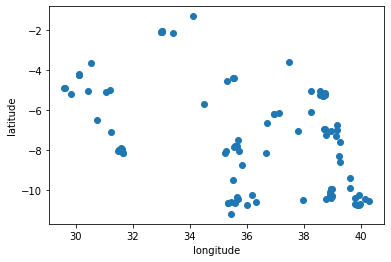

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(x=X_test_nf_location['longitude'], y=X_test_nf_location['latitude'])
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.show()

Here we can now see if there is a certain place where our target pumps are more heavily concentrated so that we can start repairs there for the sake of efficiency.